In [354]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
#
from scipy.stats import qmc # upgrade scipy for LHS !pip install scipy --upgrade

In [355]:
tf.keras.backend.set_floatx("float64")

In [356]:
### generating data

# number of boundary and initial data points
# value `Nd` in the reference paper:
# Nd = number_of_ic_points + number_of_bc1_points + number_of_bc1_points 
number_of_ic_points = 50
number_of_bc1_points = 25
number_of_bc2_points = 25

# Latin Hypercube Sampling (LHS) engine ; to sample random points in domain,
# boundary and initial boundary
engine = qmc.LatinHypercube(d=1)

# temporal data points
t_d = engine.random(n=number_of_bc1_points + number_of_bc2_points)
temp = np.zeros([number_of_ic_points, 1]) # for IC ; t = 0
t_d = np.append(temp, t_d, axis=0)
# spatial data points
x_d = engine.random(n=number_of_ic_points)
x_d = 2 * (x_d - 0.5)
temp1 = -1 * np.ones([number_of_bc1_points, 1]) # for BC1 ; x = -1
temp2 = +1 * np.ones([number_of_bc2_points, 1]) # for BC2 ; x = +1
x_d = np.append(x_d, temp1, axis=0)
x_d = np.append(x_d, temp2, axis=0)

Text(0.5, 1.0, 'Data points (BCs & IC)')

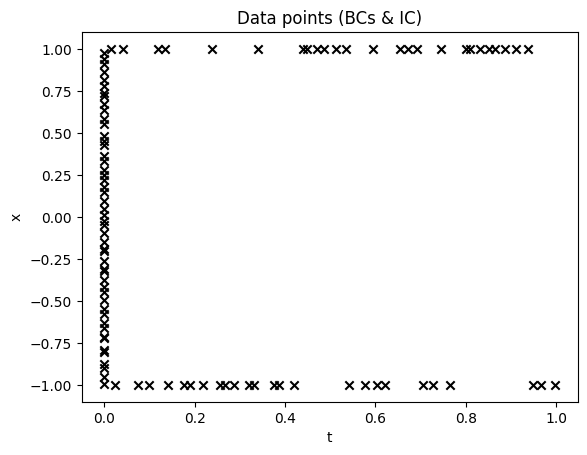

In [357]:
# view randomly sampled boundary and initial points
plt.scatter(t_d, x_d, marker="x", c="k")  
plt.xlabel("t")
plt.ylabel("x")
plt.title("Data points (BCs & IC)")

In [358]:
# output values for data points (boundary and initial)
y_d = np.zeros(x_d.shape)

# for initial condition: IC = -sin(pi*x)
y_d[ : number_of_ic_points] = -np.sin(np.pi * x_d[:number_of_ic_points])

# all boundary conditions are set to zero
y_d[number_of_ic_points : number_of_bc1_points + number_of_ic_points] = 0
y_d[number_of_bc1_points + number_of_ic_points : number_of_bc1_points + number_of_ic_points + number_of_bc2_points] = 0

In [359]:
# number of collocation points
Nc = 10000

# LHS for collocation points
engine = qmc.LatinHypercube(d=2)
data = engine.random(n=Nc)
# set x values between -1. and +1.
data[:, 1] = 2*(data[:, 1]-0.5)

# change names
t_c = np.expand_dims(data[:, 0], axis=1)
x_c = np.expand_dims(data[:, 1], axis=1)

In [360]:
# convert all data and collocation points to tf.Tensor
x_d, t_d, y_d, x_c, t_c = map(tf.convert_to_tensor, [x_d, t_d, y_d, x_c, t_c])

In [361]:
### model design
#
neuron_per_layer = 50
#num_hidden_layers = 8
# activation function for all hidden layers
actfn = "tanh"

# input layer
input_layer = tf.keras.layers.Input(shape=(2,))

# hidden layer
# also a for loop could be used instead of multiple lines of code
hidden0 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(input_layer)
hidden1 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden0)
hidden2 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden1)
hidden3 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden2)
hidden4 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden3)
hidden5 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden4)
hidden6 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden5)
hidden7 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden6)
hidden8 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden7)
hidden9 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden8)
hidden10 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden9)
hidden11 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden10)
hidden12 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden11)
hidden13 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden12)
hidden14 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden13)

# hidden0 = tf.keras.layesr.Dense(neurons_per_layer, activation=actfn)(input_layer)
# for hidden in range(1, num_hidden_layers):
#     hidden = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden)

# output layer
output_layer = tf.keras.layers.Dense(1, activation=None)(hidden14)

model = tf.keras.Model(input_layer, output_layer)

model.summary()

Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_392 (Dense)           (None, 50)                150       
                                                                 
 dense_393 (Dense)           (None, 50)                2550      
                                                                 
 dense_394 (Dense)           (None, 50)                2550      
                                                                 
 dense_395 (Dense)           (None, 50)                2550      
                                                                 
 dense_396 (Dense)           (None, 50)                2550      
                                                                 
 dense_397 (Dense)           (None, 50)                255

In [362]:
# u(t, x) just makes working with model easier and the whole code looks more
# like its mathematical backend
@tf.function
def u(t, x):
    # model input shape is (2,) and `u` recieves 2 arguments with shape (1,)
    # to be able to feed those 2 args (t, x) to the model, a shape (2,) matrix
    # is build by simply concatenation of (t, x)
    u = model(tf.concat([t, x], axis=1)) # note the axis ; `column`
    return u

In [363]:
# the physics informed loss function
# IMPORTANT: this loss function is used for collocation points
@tf.function
def f(t, x):
    u0 = u(t, x)
    u_t = tf.gradients(u0, t)[0]
    u_x = tf.gradients(u0, x)[0]
    u_xx = tf.gradients(u_x, x)[0]
    F = u_t + u0*u_x - (0.01/np.pi)*u_xx
    return tf.reduce_mean(tf.square(F))

In [364]:
# MSE loss function
# IMPORTANT: this loss function is used for data points
@tf.function
def mse(y, y_):
    return tf.reduce_mean(tf.square(y-y_))

In [365]:
import time

In [366]:
"""
BENCHMARK on Local Machine

Nu = 25 + 25 + 50
Nf = 10000
hidden = 9x20

learning_rate = 5e-4
epochs = 2000
training time ~ 8m 50s
final loss = 0.009
"""

"""
Nu = 50 + 50 + 100
Nf = 20000
hidden = 12x40
epochs = 2000
"""

epochs = 3000
loss_list = []

# L-BFGS optimizer was used in the reference paper
opt = tf.keras.optimizers.Adam(learning_rate=5e-4)
start = time.time()

# training loop
# IMPORTANT: a while-based training loop is more beneficial
# updates the model while loss > 0.006
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        # model output/prediction
        y_ = u(t_d, x_d)
        # physics-informed loss for collocation points
        L1 = f(t_c, x_c)
        # MSE loss for data points
        L2 = mse(y_d, y_)
        loss = L1 + L2
    # compute gradients
    g = tape.gradient(loss, model.trainable_weights)
    loss_list.append(loss)
    # log every 10 epochs
    if (not epoch%10) or (epoch == epochs-1):
        print(f"{epoch:4} {loss.numpy():.3f}")
    # apply gradients
    opt.apply_gradients(zip(g, model.trainable_weights))

end = time.time()
print(f"{end - start:.3} (s)")

   0 0.477
  10 0.201
  20 0.178
  30 0.149
  40 0.145
  50 0.138
  60 0.135
  70 0.129
  80 0.120
  90 0.108
 100 0.100
 110 0.096
 120 0.094
 130 0.093
 140 0.091
 150 0.090
 160 0.088
 170 0.086
 180 0.083
 190 0.081
 200 0.079
 210 0.077
 220 0.073
 230 0.070
 240 0.068
 250 0.068
 260 0.064
 270 0.063
 280 0.061
 290 0.060
 300 0.061
 310 0.058
 320 0.057
 330 0.056
 340 0.057
 350 0.054


Text(0.5, 0, 'epoch')

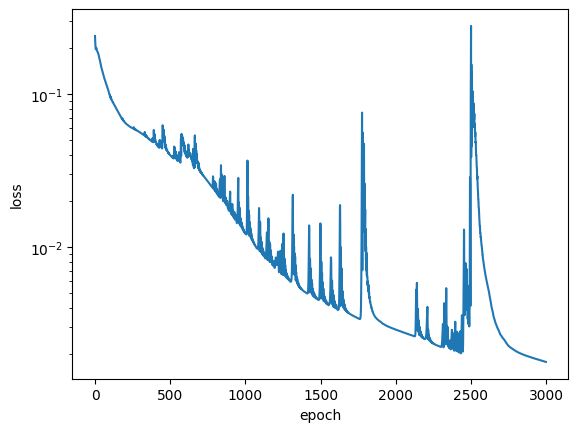

In [ ]:
plt.semilogy(range(epochs), loss_list)
plt.ylabel("loss")
plt.xlabel("epoch")
#plt.savefig("loss vs epoch 6x20")

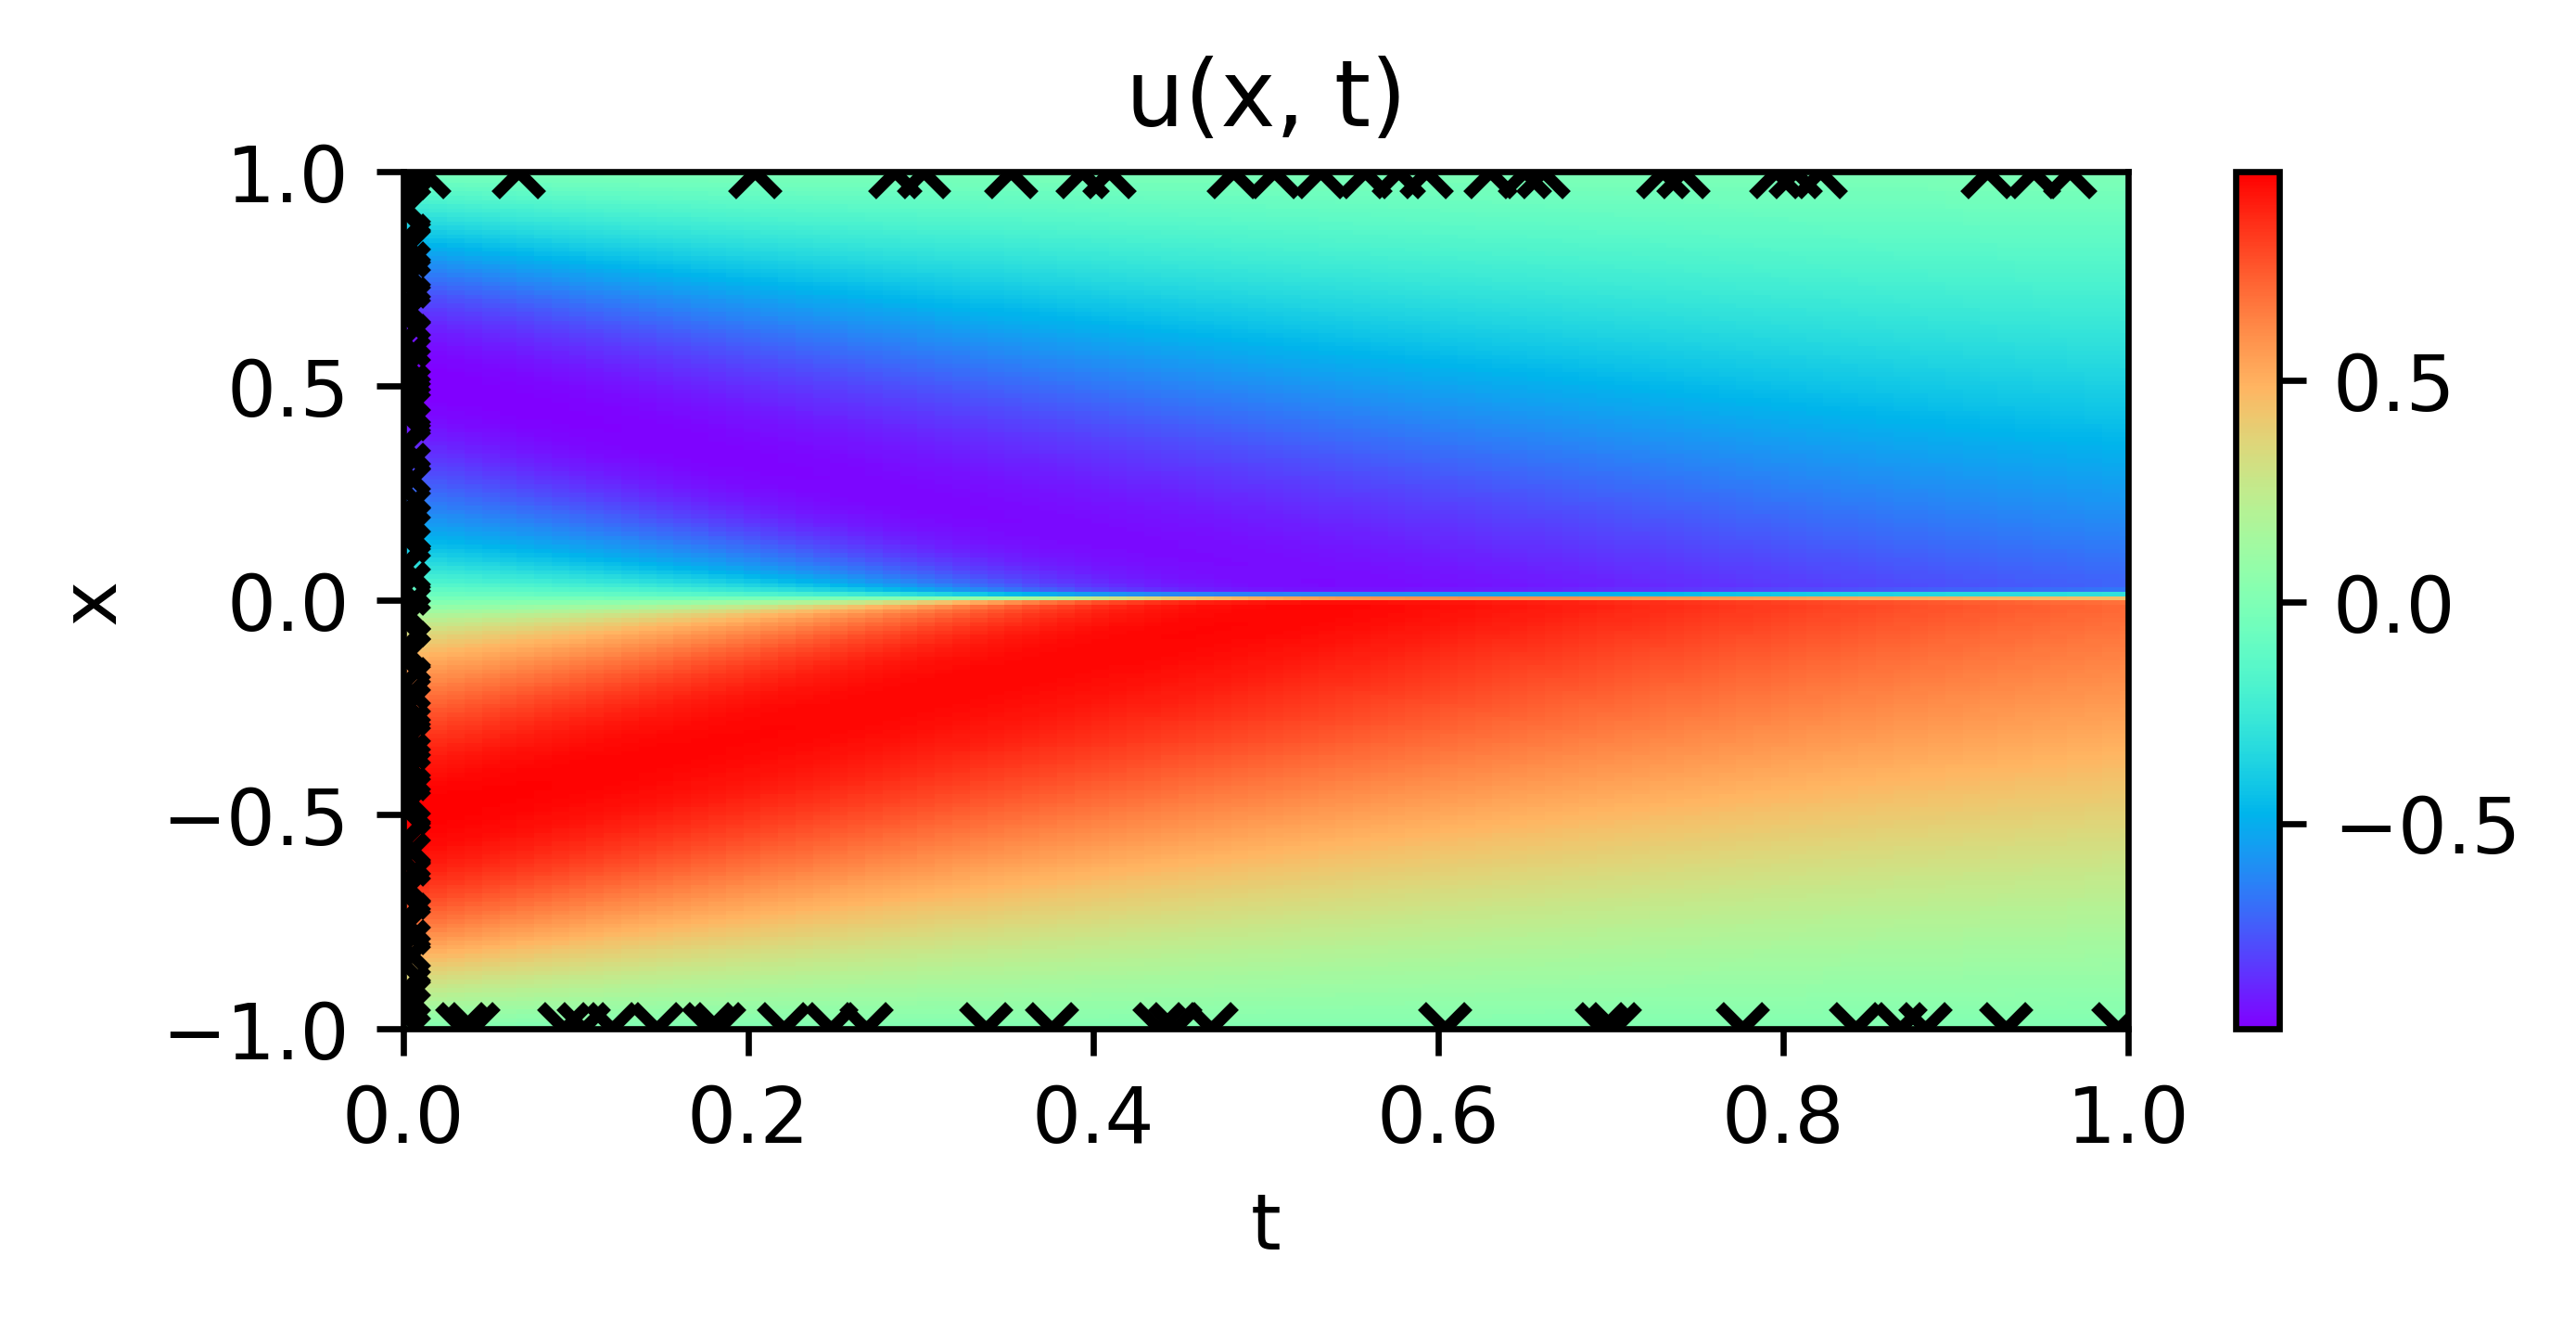

In [ ]:
### plot
# another code is also available for ploting
n, m = 100, 200
X = np.linspace(-1, +1, m)
T = np.linspace(0, 1, n)
X0, T0 = np.meshgrid(X, T)
X = X0.reshape([n*m, 1])
T = T0.reshape([n*m, 1])
X = tf.convert_to_tensor(X)
T = tf.convert_to_tensor(T)
X.shape, T.shape
plt.figure(figsize=(5, 2), dpi=600)
S = u(T, X)
S = S.numpy().reshape(n, m)
plt.pcolormesh(T0, X0, S, cmap=cm.rainbow)
plt.colorbar()
plt.xlim(0., +1)
plt.ylim(-1, +1)
plt.title("u(x, t)")
plt.ylabel("x")
plt.xlabel("t")
plt.scatter(t_d, x_d, marker="x", c="k")
plt.show()

In [ ]:
# save and copy model to drive

model.save("b_14x50.h5")

In [ ]:
pinn = tf.keras.models.load_model('b_14x50.h5')

pinn.summary()

OSError: No file or directory found at b_14x50.h5